# Appliquer votre méthodologie sur le jeu de données de détection d’intrusions dans les réseaux (Kddcup99). 

<hr>

In [2]:
from utils import *

In [3]:
# Charger le dataset
df = pd.read_csv('../data/csv/KDDCup99.csv', sep=',')
print("Labels uniques avant transformation :", df['label'].unique())

Labels uniques avant transformation : ['normal' 'buffer_overflow' 'loadmodule' 'perl' 'neptune' 'smurf'
 'guess_passwd' 'pod' 'teardrop' 'portsweep' 'ipsweep' 'land' 'ftp_write'
 'back' 'imap' 'satan' 'phf' 'nmap' 'multihop' 'warezmaster' 'warezclient'
 'spy' 'rootkit']


In [4]:
for col in df.columns:
    print(f"Valeurs uniques dans {col} : {df[col].unique()}")

Valeurs uniques dans duration : [   0    1   79 ... 2695 2751  120]
Valeurs uniques dans protocol_type : ['tcp' 'udp' 'icmp']
Valeurs uniques dans service : ['http' 'smtp' 'finger' 'domain_u' 'auth' 'telnet' 'ftp' 'eco_i' 'ntp_u'
 'ecr_i' 'other' 'private' 'pop_3' 'ftp_data' 'rje' 'time' 'mtp' 'link'
 'remote_job' 'gopher' 'ssh' 'name' 'whois' 'domain' 'login' 'imap4'
 'daytime' 'ctf' 'nntp' 'shell' 'IRC' 'nnsp' 'http_443' 'exec' 'printer'
 'efs' 'courier' 'uucp' 'klogin' 'kshell' 'echo' 'discard' 'systat'
 'supdup' 'iso_tsap' 'hostnames' 'csnet_ns' 'pop_2' 'sunrpc' 'uucp_path'
 'netbios_ns' 'netbios_ssn' 'netbios_dgm' 'sql_net' 'vmnet' 'bgp' 'Z39_50'
 'ldap' 'netstat' 'urh_i' 'X11' 'urp_i' 'pm_dump' 'tftp_u' 'tim_i' 'red_i']
Valeurs uniques dans flag : ['SF' 'S1' 'REJ' 'S2' 'S0' 'S3' 'RSTO' 'RSTR' 'RSTOS0' 'OTH' 'SH']
Valeurs uniques dans src_bytes : [181 239 235 ... 500 484 475]
Valeurs uniques dans dst_bytes : [ 5450   486  1337 ... 34557 10592 13828]
Valeurs uniques dans land : [0 

In [ ]:
# Afficher les protocoles présents dans la colonne 'protocol_type'
df['protocol_type'].unique()

array(['tcp', 'udp', 'icmp'], dtype=object)

In [26]:
df['label'] = np.where(df['label'] == 'normal', 0, 1)
print("Labels après transformation :", df['label'].value_counts())

Labels après transformation : label
1    396743
0     97277
Name: count, dtype: int64


In [27]:
# Séparer les normales et les anomalies
X = df.drop(columns=['label'])
Y = df['label']

In [28]:
X_normal = X[Y == 0]
Y_normal = Y[Y == 0]

In [29]:

X_anomalie = X[Y == 1]
Y_anomalie = Y[Y == 1]

In [30]:
# Nombre d’échantillons pour équilibrer
taille_echantillon = min(len(X_normal), len(X_anomalie))
taille_echantillon

97277

In [31]:
X_normal_sampled = X_normal.sample(taille_echantillon, random_state=42)
Y_normal_sampled = Y_normal.sample(taille_echantillon, random_state=42)

In [32]:
X_anomalie_sampled = X_anomalie.sample(taille_echantillon, random_state=42)
Y_anomalie_sampled = Y_anomalie.sample(taille_echantillon, random_state=42)


In [ ]:
# Fusion des datasets équilibrés
X_final = pd.concat([X_normal_sampled, X_anomalie_sampled], axis=0)
Y_final = pd.concat([Y_normal_sampled, Y_anomalie_sampled], axis=0)
print(f" Dataset équilibré : {sum(Y_final == 0)} normales | {sum(Y_final == 1)} anomalies")

 Dataset équilibré : 97277 normales | 97277 anomalies


In [34]:
# Encoder les variables catégoriques
X_final_encoded = pd.get_dummies(X_final, columns=['protocol_type', 'service', 'flag'])

In [35]:
print(X_final_encoded.dtypes)

duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1            bool
flag_S2            bool
flag_S3            bool
flag_SF            bool
flag_SH            bool
Length: 117, dtype: object


In [36]:
# Appliquer PCA depuis `utils.py`
# X_final_pca = apply_pca(X_final_encoded, n_components=30)

In [37]:
# Normalisation avec RobustScaler depuis `utils.py`
X_scaled = RobScaler(X_final_encoded)

In [38]:
# Split dataset en train/test

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_final, test_size=0.3, stratify=Y_final, random_state=42)

print("Données prêtes pour l'entraînement")

Données prêtes pour l'entraînement


In [39]:
# Définition de la pipeline
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10,
                             min_samples_leaf=5, max_features='sqrt', class_weight="balanced", random_state=1)

In [40]:
clf = RandomForestClassifier()
P = Pipeline([
    ('ss', StandardScaler()),
    ('FS', SelectFromModel(clf, max_features=30)),
    ('classifier', clf)
])

# Entraînement du pipeline
P.fit(X_train, Y_train)
print("Pipeline entraînée avec succès !")

Pipeline entraînée avec succès !


In [41]:
with open('../artifacts/model.pkl', 'wb') as model_file:
    pickle.dump(P, model_file)

print("Modèle sauvegardé dans artifacts/model.pkl")

Modèle sauvegardé dans artifacts/model.pkl


In [42]:
# Prédictions
Y_pred = P.predict(X_test)

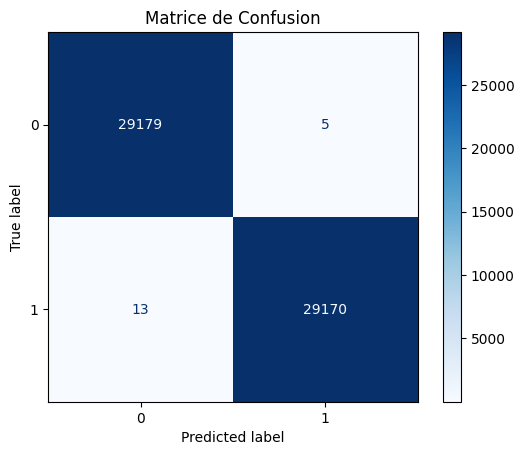

 Rapport de Classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29184
           1       1.00      1.00      1.00     29183

    accuracy                           1.00     58367
   macro avg       1.00      1.00      1.00     58367
weighted avg       1.00      1.00      1.00     58367



In [43]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()

# Rapport de classification
print(" Rapport de Classification :")
print(classification_report(Y_test, Y_pred))

In [45]:
import requests
response = requests.post("http://localhost:8000/predict", json={"features": [0, "tcp", "http", "SF", 181, 5450, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 9, 9, 1.00, 0.00, 0.11, 0.00, 0.00, 0.00, 0.00, 0.00]})
print(response.json())

{'prediction': 1}
